In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
import math
import Physical_Const as phys
import pwlf

epsilon = np.finfo(float).eps

h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass
rho0 = phys.rho0


rhodim=mn**4.0*c**3.0/(8.0*np.pi**2*(h/(2.0*np.pi))**3.0) #Dimensions of energy density
rdim=c/np.sqrt(rhodim*G) # Dimensions of radius
mdim=rdim*c**2.0/G # Dimensions of mass
Pdim=rhodim*c**2 # Dimensions of pressure
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rcParams["figure.figsize"] = (8,6)

Load equation of state

In [1]:
brhoSLy,PSLy, rhoSLy=np.loadtxt('EOS/sly.dat',usecols=(0,1,2),unpack=True)
#brhoSLy = brhoSLy/rhodim
PSLy = PSLy*c**2
#rhoSLy = rhoSLy/rhodim

NameError: name 'np' is not defined

Apply logarithm

In [3]:
logbrho  = np.log10(brhoSLy)
logP = np.log10(PSLy)

Fit with 9 segments

In [4]:
polyfit1 = pwlf.PiecewiseLinFit(logbrho, logP)

res = polyfit1.fit(9)

In [5]:
print('Suma residual de cuadrados\n',polyfit1.ssr) # sum-of-squares error
print('Puntos de unión \n',polyfit1.fit_breaks) # breakpoint locations
#print(polyfit1.n_parameters) # number of model parameters
#print(polyfit1.n_segments) # number of line segments
#print(polyfit1.beta) # model parameters
print('Pendientes\n',polyfit1.slopes) # slope of each line segment
print('Interceptos\n',polyfit1.intercepts) # y intercepts of

Suma residual de cuadrados
 0.004015697398911294
Puntos de unión 
 [ 1.11905582  6.53249722  8.27157124 10.65857648 11.73826487 12.37406684
 13.82034135 14.18011566 15.1340731  15.41043979]
Pendientes
 [1.60766552 1.40966027 1.29285637 1.20693622 0.52673644 1.33059642
 1.57563844 2.95230483 2.78510201]
Interceptos
 [12.68367464 13.97714342 14.94329518 15.85908172 23.84344691 13.89642977
 10.50986535 -9.01142321 -6.48096358]


Guardar a archivo

In [6]:
np.savetxt('polyfit.txt', np.c_[polyfit1.fit_breaks[1:],polyfit1.slopes,polyfit1.intercepts],delimiter='\t')

Getting rid of units

In [7]:
rhobreaks = (10**polyfit1.fit_breaks)/rhodim
Pbreaks = (10**polyfit1.predict(polyfit1.fit_breaks))/Pdim
Gammas = polyfit1.slopes
ks = np.zeros_like(Gammas)
for i in range(len(Gammas)):
    ks[i] = (10**polyfit1.intercepts[i])*((rhodim**Gammas[i])/Pdim)

In [8]:
def P_EOS(brho):
    # find the breakpoint closest to the desired density
    i = np.abs(rhobreaks-brho).argmin()  
    # identifying the interval
    if brho <= rhobreaks[i]:
        return ks[i-1]*(brho**Gammas[i-1])
    else:
        return ks[i]*(brho**Gammas[i])
    
def rhos_EOS(P):
    i = np.abs(Pbreaks-P).argmin()
    if P <= Pbreaks[i]:
        return (P/ks[i-1])**(1/Gammas[i-1]), (P/ks[i-1])**(1/Gammas[i-1]) + (1/(Gammas[i-1]-1))*P
    else:
        return (P/ks[i-1])**(1/Gammas[i-1]), (P/ks[i])**(1/Gammas[i]) + (1/(Gammas[i]-1))*P

In [9]:
def RK4(f, r, y, dr):
    """Propagates the solver one step further. Takes as inputs the RHS of the system f, the current location r,
    the current value of the variables y, and the stepsize. Returns the value of the variables in location r+dr."""
    k1,l1,n1 = f(r,y)
    
    k2,l2,n2 = f(r+0.5*dr,[y[0]+0.5*dr*k1,y[1]+0.5*dr*l1,y[2]+0.5*dr*n1])   
    
    k3,l3,n3 = f(r+0.5*dr,[y[0]+0.5*dr*k2,y[1]+0.5*dr*l2,y[2]+0.5*dr*n2])
    
    k4,l4,n4 = f(r+dr,[y[0]+dr*k3,y[1]+dr*l3,y[2]+dr*n3])
    
    k=(dr/6)*(k1+2.0*k2+2.0*k3+k4)
    l=(dr/6)*(l1+2.0*l2+2.0*l3+l4)
    n=(dr/6)*(n1+2.0*n2+2.0*n3+n4)
    
    return [y[0]+k,y[1]+l,y[2]+n]

In [10]:
delta=0.15
def stepsize(y,dy):
    """Adaptive stepsize. It takes the current value of the variables and it's gradients. The parameter delta is defined externally."""
    return delta*((1/y[0])*dy[0]-(1/y[1])*dy[1])**(-1)

In [11]:
def static(P_c,r0,dr0,rhosEoS,cutoff=0.0):
    
    def TOV(r,y):
        mns, pns, nuns= y
        dmdr=4.0*np.pi*r**2.0*rhosEoS(pns)[1]
        if (1.0-(rhosEoS(pns)[1]/rhosEoS(y0[1])[1]))<(2*epsilon):
            dpdr=-4*np.pi*((pns+rhosEoS(y0[1])[1])*(rhosEoS(y0[1])[1]/3+pns)/(1-(8*np.pi/3)*r**2*rhosEoS(y0[1])[1]))*r
            #print('h')
        else:
            dpdr=-((4.0*np.pi*r**3.0*pns+mns)*(pns+rhosEoS(pns)[1]))/(r*(r-2.0*mns))
        dnudr=-dpdr/(pns+rhosEoS(pns)[1])
        #print('P',pns*Pdim,'rho',rhosEoS(pns)*rhodim)
        #print('r',r)
        return [dmdr,dpdr,dnudr]
    
    y0=[0,P_c,0]
    ms=[]; ps=[]; rhos=[]; nus=[]; rs=[]  # creating lists to save the solution  
    ms.append(y0[0]); ps.append(y0[1]); rhos.append(rhosEoS(y0[1])[1]); nus.append(y0[2]); rs.append(r0) 
    y=RK4(TOV,r0,y0,dr0) # first step taken arbitrary (dr0)  
    dr=dr0
    r=r0+dr 
    #ms.append(y[0]); ps.append(y[1]); rhos.append(rhosEoS(y[1])[1]); nus.append(y[2]); rs.append(r) 
    while y[1] > 0 and rhosEoS(y[1])[0]*rhodim > cutoff and dr>2*epsilon:
        ms.append(y[0]); ps.append(y[1]); rhos.append(rhosEoS(y[1])[1]); nus.append(y[2]); rs.append(r) 
        #print('h2')
        #print('P',y[1],'m',y[0],'r',r,'dr',dr)
        dr=stepsize(y,TOV(r,y))
        y=RK4(TOV,r,y,dr)
        r=r+dr
    return np.array([ms,ps,rhos,nus,rs])

In [12]:
brhoc1 = 10.0**15
r0=0
dr0=1e-6

In [13]:
m1,p1,rho1,nu1,r1 = static(P_EOS(brhoc1/rhodim),r0,dr0,rhos_EOS,cutoff=(1+0.005)*np.amin(brhoSLy))

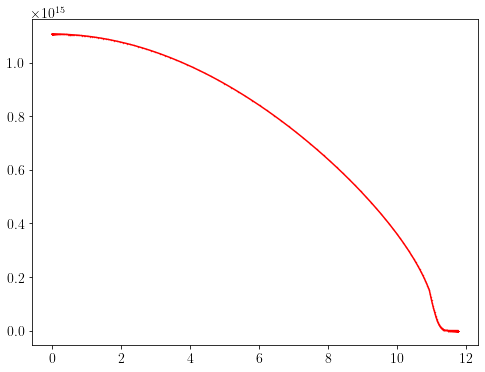

In [14]:
plt.plot(r1*rdim*1e-5,rho1*rhodim,color='red',marker='o',markersize='0.4') 

In [15]:
brhoc2 = 10.0**(14.5)
m2,p2,rho2,nu2,r2 = static(P_EOS(brhoc2/rhodim),r0,dr0,rhos_EOS,cutoff=(1+0.005)*np.amin(rhoSLy))

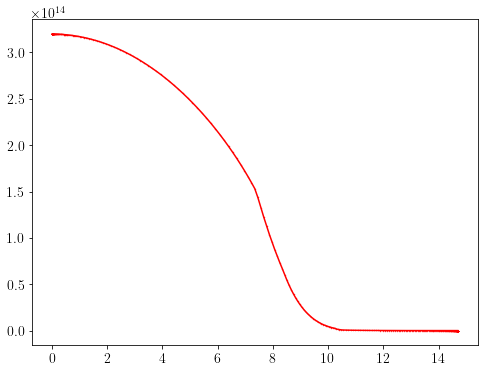

In [16]:
plt.plot(r2*rdim*1e-5,rho2*rhodim,color='red',marker='o',markersize='0.4') 

## Introducing anisotropy

\begin{align}
    \Delta_1 &= \beta_H P \frac{2m}{r} \\[5pt]
    \Delta_2 &= \beta_{BL} (\rho + P)(\rho + 3P)\frac{r^3}{r-2m}\\[5pt]
    \Delta_3 &= \beta_{HB}r\frac{dP}{dr}\\[5pt]
    \Delta_4 &= \beta_R \rho\left(1 - \frac{2m}{r}\right)\frac{dP}{dr}
\end{align}

In [17]:
def ani_static(P_c,r0,dr0,rhosEoS,bH=0.0,bBL=0.0,bHB=0.0,cutoff=0.0):
    def TOV(r,y):
        mns, pns, nuns= y
        dmdr=4.0*np.pi*r**2.0*rhosEoS(pns)[1]
        if (1.0-(rhosEoS(pns)[1]/rhosEoS(y0[1])[1]))<(2*epsilon):
            #print(bHB)
            dpdr=-4*(1-2*bHB)*np.pi*((pns+rhosEoS(y0[1])[1])*(rhosEoS(y0[1])[1]/3+pns)/ \
                    (1-(8*np.pi/3)*r**2*rhosEoS(y0[1])[1]))*r + 16*np.pi*bH*pns*r*rhosEoS(y0[1])[1]/3 \
                    +2*bBL*(rhosEoS(y0[1])[1]+pns)*(rhosEoS(y0[1])[1]+3*pns)*(r)/(1-2*(4*np.pi*r**2*rhosEoS(y0[1])[1]/3)) 
            #print(dpdr)
        else:
            dpdr=-(1-2*bHB)*((4.0*np.pi*r**3.0*pns+mns)*(pns+rhosEoS(pns)[1]))/(r*(r-2.0*mns)) \
                    +bH*pns*4*mns/r**2 + 2*bBL*(pns+rhosEoS(pns)[1])*(3*pns+rhosEoS(pns)[1])*r**2/(r-2*mns)
        dnudr=-dpdr/(pns+rhosEoS(pns)[1])
        #print('P',pns*Pdim,'rho',rhosEoS(pns)*rhodim)
        #print('r',r)
        return [dmdr,dpdr,dnudr]
    
    y0=[0,P_c,0]
    ms=[]; ps=[]; rhos=[]; nus=[]; rs=[]  # creating lists to save the solution  
    ms.append(y0[0]); ps.append(y0[1]); rhos.append(rhosEoS(y0[1])[1]); nus.append(y0[2]); rs.append(r0) 
    y=RK4(TOV,r0,y0,dr0) # first step taken arbitrary (dr0)  
    dr=dr0
    r=r0+dr 
    #ms.append(y[0]); ps.append(y[1]); rhos.append(rhosEoS(y[1])[1]); nus.append(y[2]); rs.append(r) 
    while y[1] > 0 and rhosEoS(y[1])[0]*rhodim > cutoff and dr>2*epsilon:
        ms.append(y[0]); ps.append(y[1]); rhos.append(rhosEoS(y[1])[1]); nus.append(y[2]); rs.append(r) 
        #print('h2')
        #print('P',y[1],'m',y[0],'r',r,'dr',dr)
        dr=stepsize(y,TOV(r,y))
        y=RK4(TOV,r,y,dr)
        r=r+dr
        #ms.append(y[0]); ps.append(y[1]); rhos.append(rhosEoS(y[1])[1]); nus.append(y[2]); rs.append(r) 
    return np.array([ms,ps,rhos,nus,rs])

In [18]:
m3,p3,rho3,nu3,r3 = ani_static(P_EOS(brhoc2/rhodim),r0,dr0,rhos_EOS,bHB=0.1,cutoff=(1+0.005)*np.amin(brhoSLy))

In [20]:
m4,p4,rho4,nu4,r4 = ani_static(P_EOS(brhoc2/rhodim),r0,dr0,rhos_EOS,bH=0.5,cutoff=(1+0.005)*np.amin(brhoSLy))

In [21]:
m5,p5,rho5,nu5,r5 = ani_static(P_EOS(brhoc2/rhodim),r0,dr0,rhos_EOS,bH=0.1,cutoff=(1+0.005)*np.amin(brhoSLy))

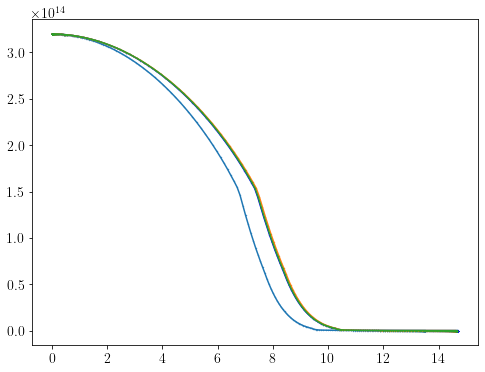

In [25]:
plt.plot(r2*rdim*1e-5,rho2*rhodim,color='blue',marker='o',markersize='0.4')
plt.plot(r3*rdim*1e-5,rho3*rhodim,marker='o',markersize='0.4')
plt.plot(r4*rdim*1e-5,rho5*rhodim,marker='o',markersize='0.4')
plt.plot(r5*rdim*1e-5,rho5*rhodim,marker='o',markersize='0.4')
plt.show()

In [27]:
ddrho2=interpolate.UnivariateSpline(r2, rho2, k=5, s=0).derivative(n=2)(r2)
ddrho3=interpolate.UnivariateSpline(r3, rho3, k=5, s=0).derivative(n=2)(r3)
ddrho4=interpolate.UnivariateSpline(r4, rho4, k=5, s=0).derivative(n=2)(r4)
ddrho5=interpolate.UnivariateSpline(r5, rho5, k=5, s=0).derivative(n=2)(r5)

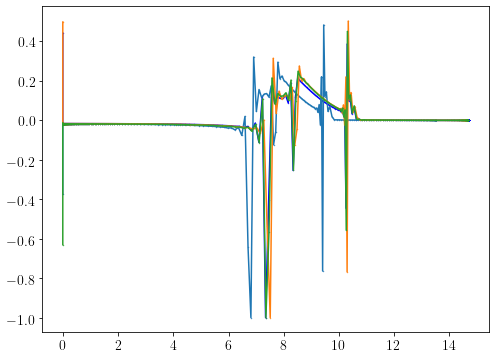

In [36]:
plt.plot(r2*rdim*1e-5,ddrho2/max(abs(ddrho2)),color='blue',marker='o',markersize='0.4')
plt.plot(r3*rdim*1e-5,ddrho3/max(abs(ddrho3)),marker='o',markersize='0.4') 
plt.plot(r4*rdim*1e-5,ddrho4/max(abs(ddrho4)),marker='o',markersize='0.4')
plt.plot(r5*rdim*1e-5,ddrho5/max(abs(ddrho5)),marker='o',markersize='0.4')
plt.show()

In [29]:
def ani_MRrhoc(r0,dr0,brhosc,rhoEoS,PEoS,bH=0.0,bBL=0.0,bHB=0.0,cutoff=0.0):
    """Builds a family of neutron star models from an equation of state P(rho) and rho(P), given a range of central densities rhosc.
    Returns three lists with the values of Rstar (RR) and Mstar (MM) for the corresponding value of rhoc (rhorho)."""
    MM=[];RR=[];rhorho=[]
    for brhoc in brhosc:
        pc = PEoS(brhoc/rhodim)
        m,p,rho,nu,r = ani_static(pc,r0,dr0,rhoEoS,bH,bBL,bHB,cutoff)
        RR.append(r[-1]*rdim*1e-5); MM.append(m[-1]*mdim/Msun); rhorho.append(rho[0]*rhodim)
    return [RR,MM,rhorho]

In [30]:
n=np.arange(14.5,np.log10(np.amax(brhoSLy)),0.005)
brhosc=10.0**n 
bHBs = np.arange(0,0.25,0.05)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


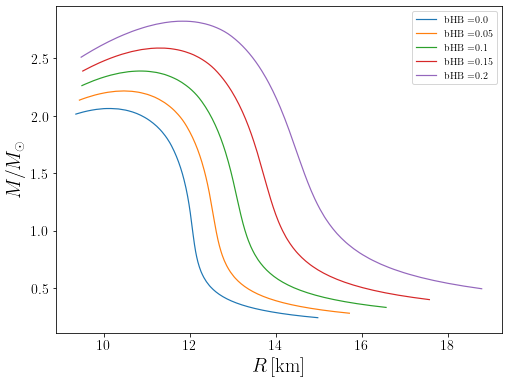

In [31]:
for bHB in bHBs:
    MRSLy=ani_MRrhoc(r0,dr0,brhosc,rhos_EOS,P_EOS,bHB=bHB,cutoff=(1+0.005)*np.amin(brhoSLy))
    plt.plot(MRSLy[0], MRSLy[1], linewidth = 1.2, label = 'bHB ='+str(np.around(bHB,3)))
plt.xlabel(r'$R\,[\rm{km}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()

In [32]:
bHs = np.arange(-1.0,1.5,0.5)

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


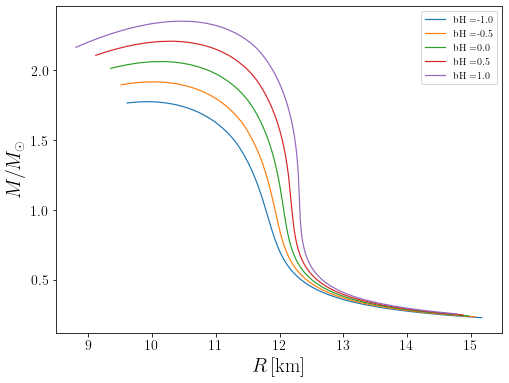

In [33]:
for bH in bHs:
    MRSLy=ani_MRrhoc(r0,dr0,brhosc,rhos_EOS,P_EOS,bH=bH,cutoff=(1+0.005)*np.amin(brhoSLy))
    plt.plot(MRSLy[0], MRSLy[1], linewidth = 1.2, label = 'bH ='+str(np.around(bH,3)))
plt.xlabel(r'$R\,[\rm{km}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()

In [34]:
bBLs = np.arange(-0.5,0.75,0.25)

In [35]:
bBLs

array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ])

/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


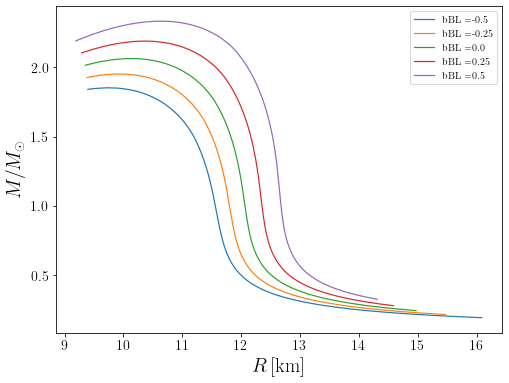

In [36]:
for bBL in bBLs:
    MRSLy=ani_MRrhoc(r0,dr0,brhosc,rhos_EOS,P_EOS,bBL=bBL,cutoff=(1+0.005)*np.amin(brhoSLy))
    plt.plot(MRSLy[0], MRSLy[1], linewidth = 1.2, label = 'bBL ='+str(np.around(bBL,3)))
plt.xlabel(r'$R\,[\rm{km}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()